# Analysing simulated serial crystallography data

In [1]:
%matplotlib inline
import io
import h5py
from h5glance import H5Glance
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd
from scipy.stats import norm

from CrystFEL_Jupyter_utilities.stream_read import search_crystals_parameters
from cfel_geom import CrystfelGeom

## Input data

In [2]:
data_dir = "../../../data/simulation/"
data_file = osp.join(data_dir, "xstal/xstal_diffr200.h5")

In [3]:
data_f = h5py.File(data_file, 'r')

In [4]:
H5Glance(data_f['data/0000001'])

Here's one frame from the simulation:

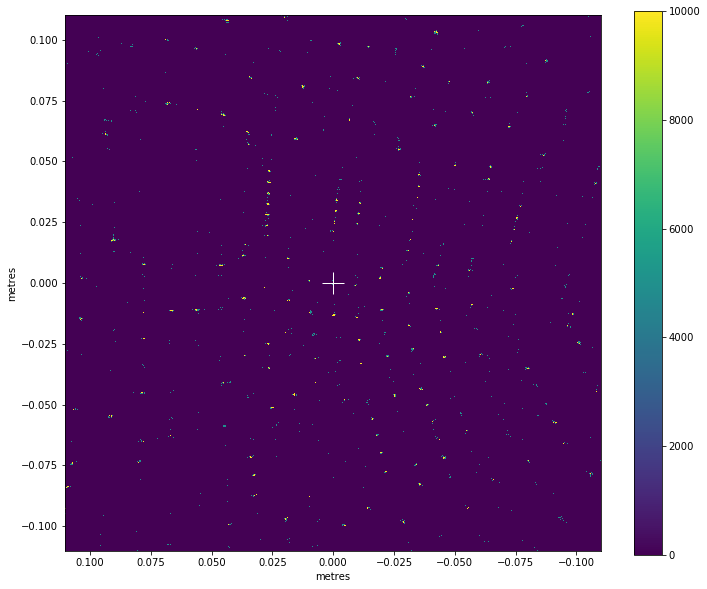

In [5]:
geom = CrystfelGeom.from_crystfel_geom('1panel.geom')
frame = data_f['data/0000001/data'][:]
fig, ax = plt.subplots(figsize=(12, 10))
geom.plot_data_fast(frame[np.newaxis], axis_units='m', ax=ax, vmin=0, vmax=10000);

## Running CrystFEL

In [6]:
with open('test.lst', 'w') as f:
    f.write(f'{data_file}\n')

In [7]:
import modules
modules.load('exfel', 'exfel_crystfel')

- EXFEL modulepath enabled
Using version 1.10.4 of HDF5
Using version 1.17 of DirAx
Using XDS BUILT 20180126


In [8]:
!time indexamajig -i test.lst -g 1panel.geom -o out.stream --peaks=zaef -j80

Unrecognised field 'px'
Unrecognised field 'py'
Unrecognised field 'pix_width'
Unrecognised field 'd'
No indexing methods specified.  I will try to automatically detect the available methods.
To disable auto-detection of indexing methods, specify which methods to use with --indexing=<methods>.
Use --indexing=none to disable indexing and integration.
No reference unit cell provided.
List of indexing methods:
   0: asdf-nolatt-nocell        (asdf - no prior information)
Indexing parameters:
                  Check unit cell parameters: off
                        Check peak alignment: on
                   Refine indexing solutions: on
 Multi-lattice indexing ("delete and retry"): off
                              Retry indexing: on
Error: Data path ends with a / symbol
   0 indexable out of    0 processed ( 0.0%),    0 crystals so far.    0 images processed since the last message.
Waiting for the last patterns to be processed...
Final: 200 images processed, 200 had crystals (100.0%), 20

## Identified peaks

In [9]:
def read_stream_table(fh, end_marker):
    buf = io.StringIO()
    for line in fh:
        if line.startswith(end_marker):
            buf.seek(0)
            return pd.read_fwf(buf)
        
        buf.write(line)

In [10]:
def read_peak_lists(stream_file):
    stream_chunks = {}

    with open(stream_file, 'r') as f:
        in_peaks_table = False
        chunk_data = {}
        for line in f:
            if '-- Begin chunk --' in line:
                chunk_data = {}
            elif '-- End chunk --' in line:
                if 'event' in chunk_data:
                    stream_chunks[chunk_data['event']] = chunk_data

            elif line.startswith('Event:'):
                chunk_data['event'] = line.split(':', 1)[1].strip()

            elif line.startswith('Peaks from peak search'):
                chunk_data['peaks'] = read_stream_table(f, 'End of peak list')
    
    return stream_chunks

In [11]:
peaks_found = read_peak_lists('out.stream')

In [12]:
peak_tbl = peaks_found['0000001//']['peaks']
peak_tbl

,fs/px,ss/px,(1/d)/nm^-1,Intensity,Panel
0,480.12,47.19,2.58,159104.00,panel0
1,434.98,81.01,2.46,192789.30,panel0
2,648.73,140.95,2.30,171471.85,panel0
3,292.50,174.24,2.29,172901.30,panel0
4,652.72,175.88,2.16,197450.55,panel0
...,...,...,...,...,...
62,556.24,866.94,2.22,169855.95,panel0
63,210.46,875.04,2.66,129272.00,panel0
64,331.26,903.97,2.52,188936.00,panel0
65,101.05,914.67,3.02,144188.00,panel0


In [13]:
module_no = np.zeros(len(peak_tbl), dtype=np.uint32)
peak_coords = geom.data_coords_to_positions(module_no, peak_tbl['ss/px'], peak_tbl['fs/px'])
peak_x = peak_coords[:, 0]
peak_y = peak_coords[:, 1]

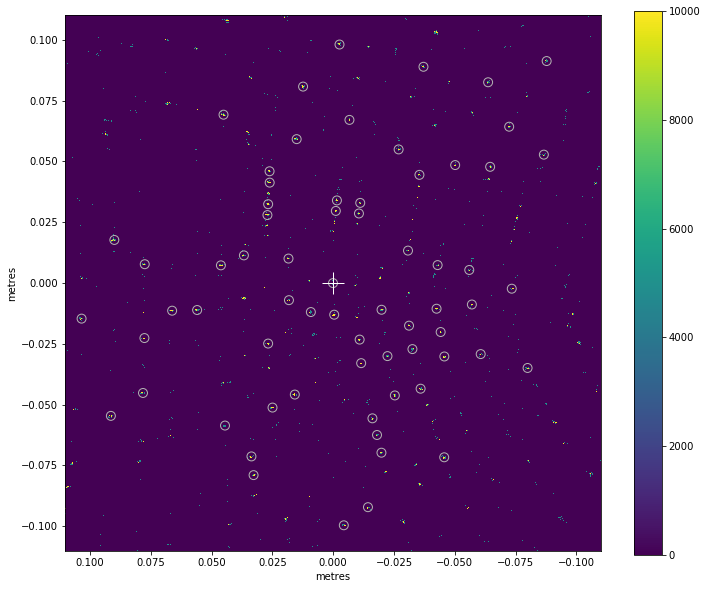

In [14]:
fig, ax = plt.subplots(figsize=(12,10))
geom.plot_data_fast(frame[np.newaxis], axis_units='m', ax=ax, vmin=0, vmax=10000)
ax.scatter(peak_x, peak_y, s=80, marker='o', facecolor='none', edgecolor='0.7');

## Examine unit cell parameters

In [15]:
params_lst = search_crystals_parameters('out.stream')
params = pd.DataFrame(params_lst).drop(columns='name').rename(columns={'alfa': 'alpha'})
params

,a,b,c,alpha,beta,gamma,centering,lattice_type,unique_axis
0,37.999398,78.896349,79.021582,90.006896,89.995111,89.916278,P,triclinic,?
1,38.038740,79.112441,78.873844,90.069455,89.991774,90.131944,P,triclinic,?
2,38.071282,78.887988,78.976084,89.822055,90.063806,90.135002,P,triclinic,?
3,38.011304,78.971396,78.989274,90.024874,89.927626,89.819763,P,triclinic,?
4,37.998553,78.940782,79.007477,89.858542,90.078724,90.072143,P,triclinic,?
...,...,...,...,...,...,...,...,...,...
195,37.970471,79.020790,79.051111,90.019164,90.141777,89.980941,P,triclinic,?
196,37.989758,78.863468,79.102665,89.922183,89.880708,90.032606,P,triclinic,?
197,37.989285,79.043379,78.941187,89.896852,90.002756,89.979023,P,triclinic,?
198,38.038932,78.940764,78.992579,90.065801,89.910198,89.950642,P,triclinic,?


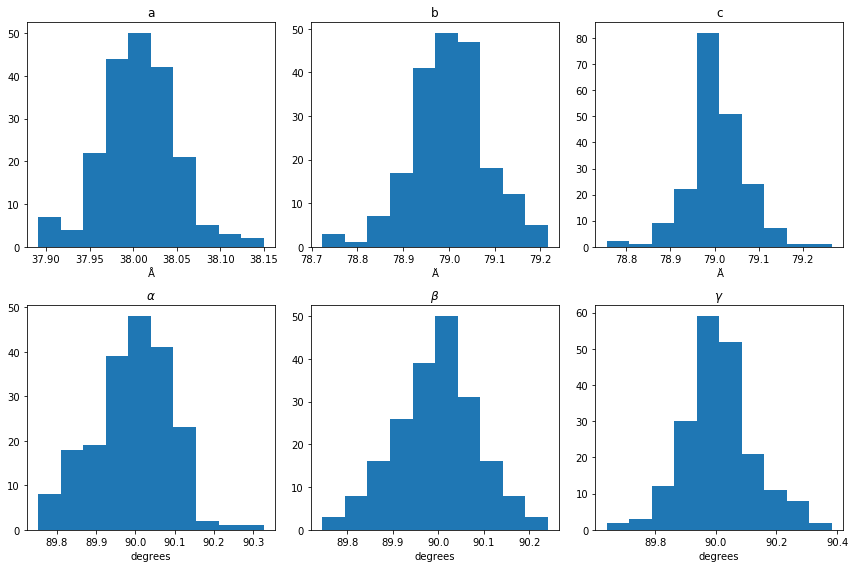

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for name, ax in zip('abc', axes[0]):
    ax.set_title(name)
    ax.set_xlabel("Å")
    ax.hist(params[name])

for name, ax in zip(('alpha', 'beta', 'gamma'), axes[1]):
    ax.set_title(f"$\\{name}$")
    ax.set_xlabel('degrees')
    ax.hist(params[name])

fig.tight_layout()

### Estimate unit cell parameters

We can estimate the value of each parameter by fitting a normal distribution to it:

In [17]:
def plot_param(name, ax, units):
    data = params[name]
    ax.set_xlabel(units)
    ax.hist(data, density=True, color='0.8')
    
    μ, σ = norm.fit(data)
    ax.text(0.05, 0.95, f"μ = {μ:.04}, σ = {σ:.03}",
            transform=ax.transAxes, fontsize=12)
    x = np.linspace(data.min(), data.max())
    ax.plot(x, norm.pdf(x, μ, σ), linestyle='--')

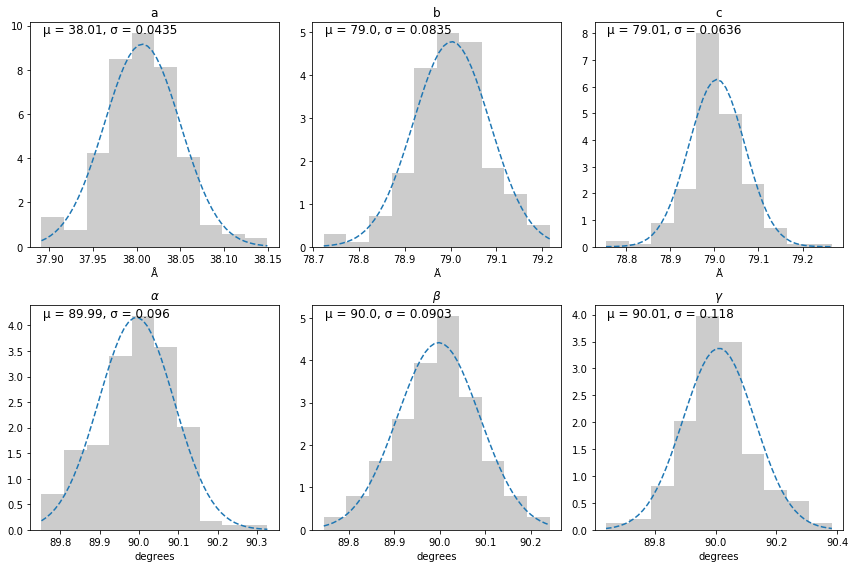

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for name, ax in zip('abc', axes[0]):
    plot_param(name, ax, "Å")
    ax.set_title(name)
    

for name, ax in zip(('alpha', 'beta', 'gamma'), axes[1]):
    plot_param(name, ax, 'degrees')
    ax.set_title(f"$\\{name}$")

fig.tight_layout()

# Simulated extreme noise

Let's repeat it with a simulation with a small number of extreme values randomly added to the results.

In [19]:
data_file = osp.join(data_dir, "superlarge_data_reduced_2.h5")

In [20]:
with open('extreme_noise.lst', 'w') as f:
    f.write(f'{data_file}\n')

In [21]:
!time indexamajig -i extreme_noise.lst -g 1panel.geom -o out-xn.stream --peaks=zaef -j80

Unrecognised field 'px'
Unrecognised field 'py'
Unrecognised field 'pix_width'
Unrecognised field 'd'
No indexing methods specified.  I will try to automatically detect the available methods.
To disable auto-detection of indexing methods, specify which methods to use with --indexing=<methods>.
Use --indexing=none to disable indexing and integration.
No reference unit cell provided.
List of indexing methods:
   0: asdf-nolatt-nocell        (asdf - no prior information)
Indexing parameters:
                  Check unit cell parameters: off
                        Check peak alignment: on
                   Refine indexing solutions: on
 Multi-lattice indexing ("delete and retry"): off
                              Retry indexing: on
Error: Data path ends with a / symbol
Waiting for the last patterns to be processed...
Final: 200 images processed, 200 had crystals (100.0%), 200 crystals overall.

real	0m5.242s
user	2m26.895s
sys	0m3.155s


In [22]:
peaks_found = read_peak_lists('out-xn.stream')

In [23]:
peak_tbl = peaks_found['0000001//']['peaks']

In [24]:
module_no = np.zeros(len(peak_tbl), dtype=np.uint32)
peak_coords = geom.data_coords_to_positions(module_no, peak_tbl['ss/px'], peak_tbl['fs/px'])
peak_x = peak_coords[:, 0]
peak_y = peak_coords[:, 1]

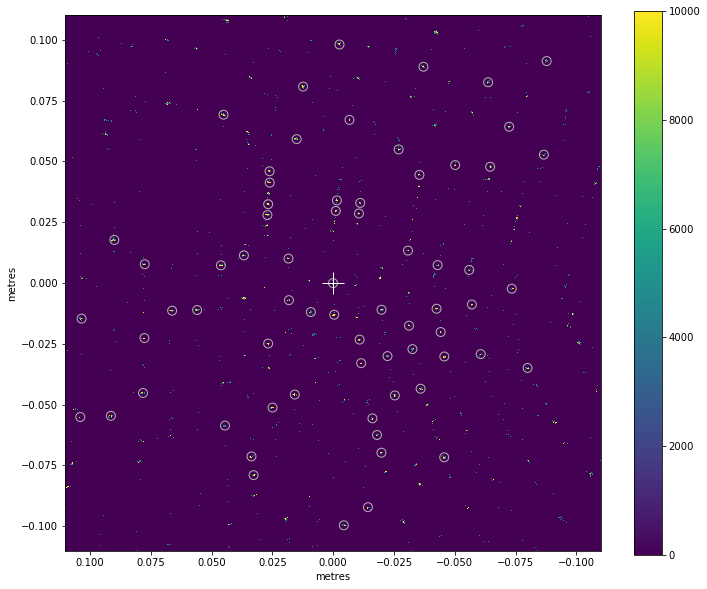

In [25]:
with h5py.File(data_file, 'r') as data_f:
    frame = data_f['data/0000001/data'][:]

fig, ax = plt.subplots(figsize=(12,10))
geom.plot_data_fast(frame[np.newaxis], axis_units='m', ax=ax, vmin=0, vmax=10000)
ax.scatter(peak_x, peak_y, s=80, marker='o', facecolor='none', edgecolor='0.7');

In [26]:
params_lst = search_crystals_parameters('out-xn.stream')
params = pd.DataFrame(params_lst).drop(columns='name').rename(columns={'alfa': 'alpha'})

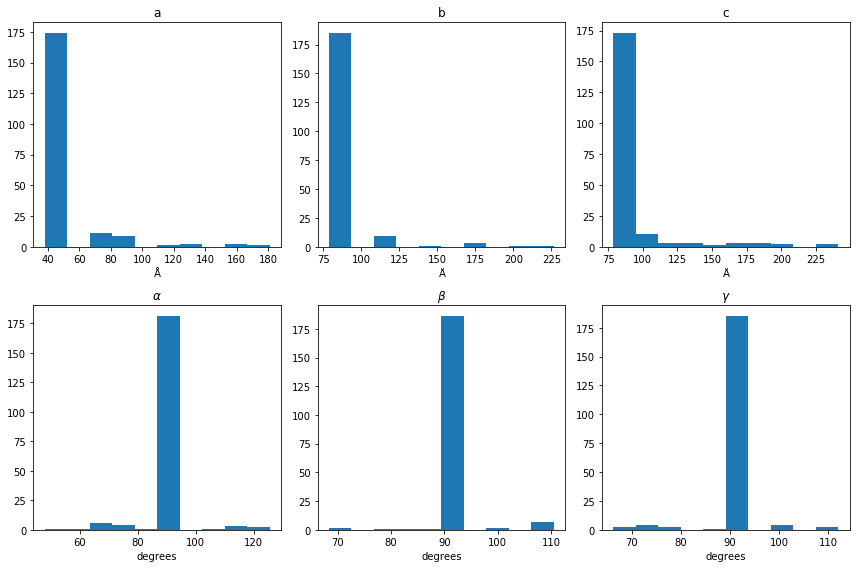

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for name, ax in zip('abc', axes[0]):
    ax.set_title(name)
    ax.set_xlabel("Å")
    ax.hist(params[name])

for name, ax in zip(('alpha', 'beta', 'gamma'), axes[1]):
    ax.set_title(f"$\\{name}$")
    ax.set_xlabel('degrees')
    ax.hist(params[name])

fig.tight_layout()

# AGIPD multi-module layout

In [39]:
data_file = osp.join(data_dir, "panoscDEMO/diffr200.h5")
geom_file = "agipd_simple_2d.geom"

Make a virtual dataset to present data as a 3D array.

In [40]:
vlayout = h5py.VirtualLayout((200, 8192, 128), dtype='f4')

frames_dir = osp.join(data_dir, "panoscDEMO/diffr200")

for i, filename in enumerate(sorted(os.listdir(frames_dir))):
    with h5py.File(os.path.join(frames_dir, filename), 'r') as f:
        vsrc = h5py.VirtualSource(f['data/data'])
    
    vlayout[i] = vsrc


with h5py.File('vdata.h5', 'w') as f:
    f.create_virtual_dataset('data/data', vlayout)

In [41]:
data_file = 'vdata.h5'
data_f = h5py.File(data_file, "r")

Here's one frame from the simulation:

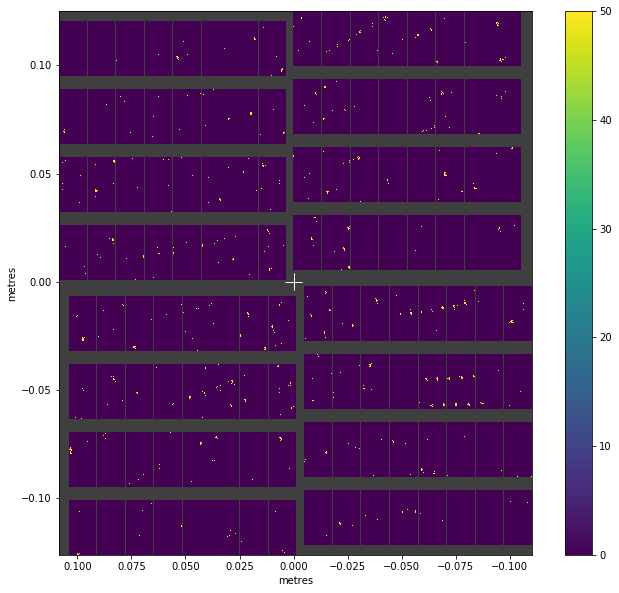

In [42]:
from extra_geom import AGIPD_1MGeometry
geom = AGIPD_1MGeometry.from_crystfel_geom(geom_file)

frame = data_f['data/data'][0].reshape(16, 512, 128)
fig, ax = plt.subplots(figsize=(12, 10))
geom.plot_data_fast(frame, axis_units='m', ax=ax, vmax=50);

In [43]:
with open('multi-panel.lst', 'w') as f:
    f.write(f'{data_file}\n')

In [44]:
!time indexamajig -i multi-panel.lst -g agipd_simple_2d.geom -o multi-panel.stream \
    --peaks=peakfinder8 --threshold 20 -j80

No indexing methods specified.  I will try to automatically detect the available methods.
To disable auto-detection of indexing methods, specify which methods to use with --indexing=<methods>.
Use --indexing=none to disable indexing and integration.
No reference unit cell provided.
List of indexing methods:
   0: asdf-nolatt-nocell        (asdf - no prior information)
Indexing parameters:
                  Check unit cell parameters: off
                        Check peak alignment: on
                   Refine indexing solutions: on
 Multi-lattice indexing ("delete and retry"): off
                              Retry indexing: on
  61 indexable out of   61 processed (100.0%),   61 crystals so far.   61 images processed since the last message.
Waiting for the last patterns to be processed...
Final: 200 images processed, 200 had crystals (100.0%), 200 crystals overall.

real	0m31.319s
user	18m6.767s
sys	0m5.991s


In [45]:
peaks_found = read_peak_lists('multi-panel.stream')
peak_tbl = peaks_found['//0']['peaks']

In [46]:
module_no = np.zeros(len(peak_tbl), dtype=np.uint32)
peak_coords = geom.data_coords_to_positions(module_no, peak_tbl['ss/px'], peak_tbl['fs/px'])
peak_x = peak_coords[:, 0]
peak_y = peak_coords[:, 1]

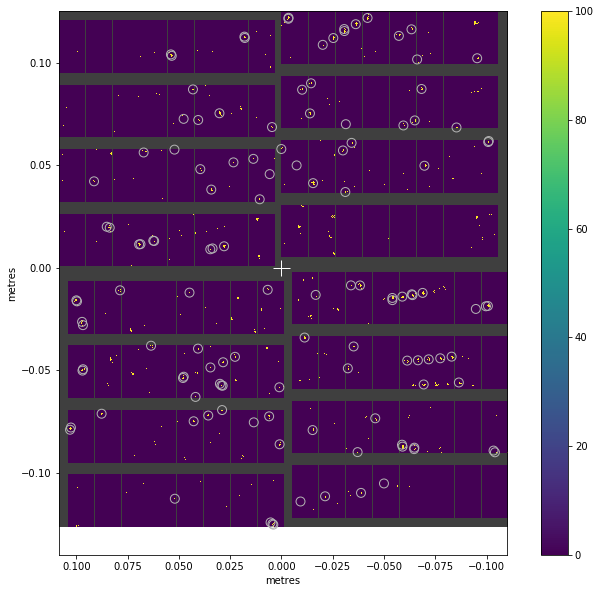

In [47]:
fig, ax = plt.subplots(figsize=(12,10))
geom.plot_data_fast(frame, axis_units='m', ax=ax, vmin=0, vmax=100)
ax.scatter(peak_x, peak_y, s=80, marker='o', facecolor='none', edgecolor='0.7');

In [48]:
params_lst = search_crystals_parameters('multi-panel.stream')
params = pd.DataFrame(params_lst).drop(columns='name').rename(columns={'alfa': 'alpha'})

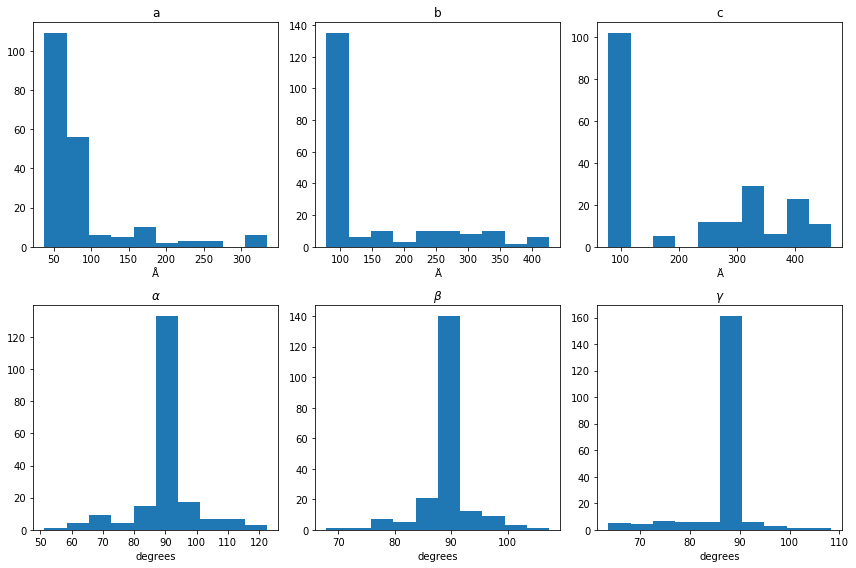

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for name, ax in zip('abc', axes[0]):
    ax.set_title(name)
    ax.set_xlabel("Å")
    ax.hist(params[name])

for name, ax in zip(('alpha', 'beta', 'gamma'), axes[1]):
    ax.set_title(f"$\\{name}$")
    ax.set_xlabel('degrees')
    ax.hist(params[name])

fig.tight_layout()

This project has received funding from the European Union's Horizon 2020 research and innovation programme under grant agreement No. 823852.